In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"

JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [3]:
import jaxley as jx
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [4]:
import dendrotweaks as dd
dd.__version__

--No graphics will be displayed.


'0.5.1'

In [4]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

In [5]:
from dendrotweaks.biophys.io import MODFileConverter

--No graphics will be displayed.


Park 2019 Channels

In [6]:
import glob

In [9]:
park_mod_dir = os.path.join("examples", "Park_2019", "biophys", "mod")
template = os.path.join("examples", "Templates", "jaxley.py")

out_dir = os.path.join("examples", "Park_2019", "biophys", "python")
os.makedirs(out_dir, exist_ok=True)

converter = MODFileConverter()

converted, failed = [], []

for mod_path in sorted(glob.glob(os.path.join(park_mod_dir, "*.mod"))):
    txt = open(mod_path, "r", encoding="utf-8", errors="ignore").read()

    base = os.path.splitext(os.path.basename(mod_path))[0] 
    out_py = os.path.join(out_dir, f"{base}jx.py") 

    try:
        converter.convert(mod_path, out_py, template)
        converted.append((mod_path, out_py))
    except Exception as e:
        failed.append((mod_path, repr(e)))

print(f"Converted: {len(converted)} | Failed: {len(failed)}")
if failed:
    print("First few failures:")
    for p, err in failed[:5]:
        print("  ", p, "->", err)

Saved content to examples/Park_2019/biophys/python/CaHVAjx.py
Saved content to examples/Park_2019/biophys/python/CaLVAjx.py
Saved content to examples/Park_2019/biophys/python/KCajx.py
Saved content to examples/Park_2019/biophys/python/Kajx.py
Saved content to examples/Park_2019/biophys/python/Kmjx.py
Saved content to examples/Park_2019/biophys/python/Kvjx.py
Saved content to examples/Park_2019/biophys/python/Najx.py
Converted: 7 | Failed: 0


In [ ]:
# from pathlib import Path

# p = Path("examples/Park_2019/biophys/python/CaHVAjx.py")
# s = p.read_text()

# s2 = s.replace("compute_kinetic_variables(vm)", "compute_kinetic_variables(v)")
# if s2 == s:
#     raise ValueError("Did not find the exact string. Open the file and patch the line manually.")

# p.write_text(s2)
# print("Patched CaHVAjx.py: vm -> v in compute_current() call")

ValueError: Did not find the exact string. Open the file and patch the line manually.

In [ ]:
# from pathlib import Path

# p = Path("examples/Park_2019/biophys/python/KCajx.py")
# s = p.read_text()
# p.write_text(s.replace("caix_KCa", "CaCon_i"))
# print("Patched KCajx.py: caix_KCa -> CaCon_i")

In [16]:
from examples.Park_2019.biophys.python.Najx import Na
from examples.Park_2019.biophys.python.Kvjx import Kv
from examples.Park_2019.biophys.python.Kmjx import Km
from examples.Park_2019.biophys.python.KCajx import KCa
from examples.Park_2019.biophys.python.Kajx import Ka
from examples.Park_2019.biophys.python.CaLVAjx import CaLVA
from examples.Park_2019.biophys.python.CaHVAjx import CaHVA
from jaxley.channels import Leak

PARK 2019 Morphology

In [ ]:
# cell = jx.read_swc("examples/Park_2019/morphology/main.swc", ncomp=1)
# print(cell.group_names)  

In [ ]:
# cell.vis()
# plt.axis("square")

In [ ]:
# print(cell.nodes[["soma","basal","apical"]].sum())

In [100]:
import numpy as np
from pathlib import Path

SWC_PATHS = [
    Path("examples/Park_2019/morphology/main.swc"),
    Path("notebooks/biophysical/examples/Park_2019/morphology/main.swc"),
]

swc_path = next((p for p in SWC_PATHS if p.exists()), None)
if swc_path is None:
    raise FileNotFoundError("Could not find main.swc in expected locations.")

def load_swc(path: Path):
    # SWC columns: id type x y z radius parent
    rows = []
    with open(path, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln or ln.startswith("#"):
                continue
            parts = ln.split()
            if len(parts) < 7:
                continue
            nid = int(float(parts[0]))
            typ = int(float(parts[1]))
            x, y, z = map(float, parts[2:5])
            r = float(parts[5])
            parent = int(float(parts[6]))
            rows.append((nid, typ, x, y, z, r, parent))
    arr = np.array(rows, dtype=float)
    return {
        "id": arr[:, 0].astype(int),
        "type": arr[:, 1].astype(int),
        "x": arr[:, 2],
        "y": arr[:, 3],
        "z": arr[:, 4],
        "r": arr[:, 5],
        "parent": arr[:, 6].astype(int),
    }

D = load_swc(swc_path)

# Map id -> index for parent lookup
id_to_idx = {nid: i for i, nid in enumerate(D["id"])}

# Compute per-node segment length (distance from node to parent) in µm
seg_len = np.zeros_like(D["x"])
has_parent = D["parent"] != -1
for i in np.where(has_parent)[0]:
    pid = D["parent"][i]
    if pid not in id_to_idx:
        continue
    j = id_to_idx[pid]
    dx = D["x"][i] - D["x"][j]
    dy = D["y"][i] - D["y"][j]
    dz = D["z"][i] - D["z"][j]
    seg_len[i] = np.sqrt(dx*dx + dy*dy + dz*dz)

# Path distance from soma root along tree (µm)
# (Assumes parent pointers form a tree; works even if soma is multiple points.)
path_dist = np.zeros_like(seg_len)
# do a topological-ish pass: repeatedly relax until stable (tree sizes are small, this is fine)
changed = True
for _ in range(10_000):
    changed = False
    for i in np.where(has_parent)[0]:
        pid = D["parent"][i]
        if pid not in id_to_idx:
            continue
        j = id_to_idx[pid]
        new = path_dist[j] + seg_len[i]
        if new > path_dist[i] + 1e-9:
            path_dist[i] = new
            changed = True
    if not changed:
        break

def summarize_type(type_id, name):
    mask = D["type"] == type_id
    if mask.sum() == 0:
        print(f"{name}: no nodes of type {type_id}")
        return

    # Length-weighted radius stats (more meaningful than raw point radii)
    w = seg_len[mask]
    r = D["r"][mask]
    wsum = w.sum()
    r_wmean = (w @ r) / max(wsum, 1e-12)

    # Total cable length (sum of child-parent segments of that type)
    L_total = wsum

    # “radius distribution” of points (unweighted)
    r_med = np.median(r)
    r_p10, r_p90 = np.percentile(r, [10, 90])

    # path distance range
    dmin, dmax = path_dist[mask].min(), path_dist[mask].max()

    print(f"{name} (type {type_id}):")
    print(f"  nodes: {mask.sum()}")
    print(f"  total length (µm): {L_total:.1f}")
    print(f"  radius (µm): weighted mean {r_wmean:.3f} | median {r_med:.3f} | p10 {r_p10:.3f} | p90 {r_p90:.3f}")
    print(f"  path distance range (µm): {dmin:.1f} to {dmax:.1f}")

print("Loaded:", swc_path)
summarize_type(1, "Soma")
summarize_type(2, "Axon")
summarize_type(3, "Basal dendrites")
summarize_type(4, "Apical dendrites")

Loaded: examples/Park_2019/morphology/main.swc
Soma (type 1):
  nodes: 3
  total length (µm): 20.4
  radius (µm): weighted mean 10.219 | median 10.219 | p10 10.219 | p90 10.219
  path distance range (µm): 0.0 to 10.2
Axon (type 2):
  nodes: 26
  total length (µm): 55.9
  radius (µm): weighted mean 0.295 | median 0.295 | p10 0.295 | p90 0.295
  path distance range (µm): 14.2 to 55.9
Basal dendrites (type 3):
  nodes: 363
  total length (µm): 863.7
  radius (µm): weighted mean 0.445 | median 0.515 | p10 0.255 | p90 0.735
  path distance range (µm): 11.7 to 203.8
Apical dendrites (type 4):
  nodes: 1822
  total length (µm): 2517.6
  radius (µm): weighted mean 0.352 | median 0.295 | p10 0.220 | p90 0.515
  path distance range (µm): 10.4 to 370.7


5 MultiCompartment Model 

In [144]:
soma_branch = jx.Branch([jx.Compartment()]) # 1 comp
basal_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps
apic_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps

cell = jx.Cell([soma_branch, basal_branch, apic_branch], parents=[-1, 0, 0])


In [ ]:
print(cell.nodes.columns)

In [145]:
v_init = -80.0
Rm = 11000.0
Ri = 100.0
Cm = 1.0

cell.set("v", v_init)
cell.set("axial_resistivity", Ri) 
cell.branch(0).set("capacitance", Cm)  # soma: 1
cell.branch(1).set("capacitance", 2 * Cm) # dend: 2
cell.branch(2).set("capacitance", 2 * Cm) # dend: 2


In [19]:
print("soma:")
print(cell.branch(0).nodes[["length","radius", "capacitance"]])
print("basal:")
print(cell.branch(1).nodes[["length","radius", "capacitance"]])
print("apical:")
print(cell.branch(2).nodes[["length","radius", "capacitance"]])

soma:
   length  radius  capacitance
0    10.0     1.0          1.0
basal:
   length  radius  capacitance
1    10.0     1.0          2.0
2    10.0     1.0          2.0
apical:
   length  radius  capacitance
3    10.0     1.0          2.0
4    10.0     1.0          2.0


In [146]:
# soma
cell.branch(0).comp(0).set("length", 20)
cell.branch(0).comp(0).set("radius", 10)

cell.branch(1).comp(0).set("length", 100.0)   # prox
cell.branch(1).comp(0).set("radius", 0.50)
cell.branch(1).comp(1).set("length", 100.0)   # dist
cell.branch(1).comp(1).set("radius", 0.5)


cell.branch(2).comp(0).set("length", 100.0)   # prox
cell.branch(2).comp(0).set("radius", 0.5)
cell.branch(2).comp(1).set("length", 100.0)   # dist
cell.branch(2).comp(1).set("radius", 0.5)

In [137]:
print("soma:")
print(cell.branch(0).nodes[["length","radius", "capacitance"]])
print("basal:")
print(cell.branch(1).nodes[["length","radius", "capacitance"]])
print("apical:")
print(cell.branch(2).nodes[["length","radius", "capacitance"]])

soma:
   length  radius  capacitance
0    20.0    10.0          1.0
basal:
   length  radius  capacitance
1   100.0     0.5          2.0
2   100.0     0.5          2.0
apical:
   length  radius  capacitance
3   100.0     0.5          2.0
4   100.0     0.5          2.0


In [147]:
cell.insert(Leak())
cell.set("Leak_gLeak", 1.0 / Rm)
cell.set("Leak_eLeak", v_init) 

In [148]:
temperature = 37.0

channels = [Na(), Kv(), Km(), Ka()]  

for ch in channels:
    if hasattr(ch, "set_tadj"):
        try: ch.set_tadj(temperature)
        except: pass
    ch.temperature = temperature  # needed for Ka

cell.insert(Leak())
for ch in channels:
    cell.insert(ch)

In [ ]:
# temperature = 37.0

# channels = [Na(), Kv(), Km(), Ka(), KCa(), CaHVA(), CaLVA()]

# for ch in channels:
#     ch.set_tadj(temperature) 
#     ch.temperature = temperature # only works if method exists

# Na().channel_params["E_na"] = 60.0
# Kv().channel_params["E_k"] = -80.0
# Km().channel_params["E_k"] = -80.0
# KCa().channel_params["E_k"] = -80.0
# Ka().channel_params["E_k"] = -80.0
# CaHVA().channel_params["E_ca"] = 140.0
# CaLVA().channel_params["E_ca"] = 140.0

# for ch in channels:
#     cell.insert(ch)

In [ ]:
print(cell.nodes.columns)

In [ ]:
def cols_for_chan(chan):
    suffix = f"_{chan}".lower()
    return [c for c in cell.nodes.columns if c.lower().endswith(suffix)]

for ch in ["Na", "Kv", "Km", "Ka", "KCa", "CaHVA", "CaLVA"]:
    print(ch, cols_for_chan(ch))

In [ ]:
soma = cell.branch(0)
dend = [cell.branch(1), cell.branch(2)]

soma.set("gbar_Na", 50.9)
soma.set("gbar_Kv", 50.0)
soma.set("gbar_Km", 2.794)
soma.set("gbar_Ka", 0.0054)
# soma.set("gbar_KCa", 0.0)
# soma.set("gbar_CaHVA", 0.05)
# soma.set("gbar_CaLVA", 3e-5)

for br in dend:
    br.set("gbar_Na", 30.94)
    br.set("gbar_Kv", 1.5)
    br.set("gbar_Km", 1.27)
    br.set("gbar_Ka", 0.108)
    # br.set("gbar_KCa", 0.0)
    # br.set("gbar_CaHVA", 0.05)
    # br.set("gbar_CaLVA", 3e-5)

In [ ]:
print(cell.branch(0).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka"]])
print(cell.branch(1).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka"]])

   gbar_Na  gbar_Kv  gbar_Km  gbar_Ka
0    504.9     50.0    2.794   0.0054
   gbar_Na  gbar_Kv  gbar_Km  gbar_Ka
1   302.94      1.5     1.27    0.108
2   302.94      1.5     1.27    0.108


In [109]:
gca_dend = 0.05
git_dend = 3e-5

Lb0 = float(cell.branch(1).comp(0).nodes["length"].iloc[0])
Lb1 = float(cell.branch(1).comp(1).nodes["length"].iloc[0])
La0 = float(cell.branch(2).comp(0).nodes["length"].iloc[0])
La1 = float(cell.branch(2).comp(1).nodes["length"].iloc[0])

# centers (µm)
x_basal = [0.5*Lb0, Lb0 + 0.5*Lb1]
x_apic  = [0.5*La0, La0 + 0.5*La1]

# basal: linear increase
for comp, x in enumerate(x_basal):
    cell.branch(1).comp(comp).set("gbar_CaHVA", gca_dend * (1 + 0.002*x))
    cell.branch(1).comp(comp).set("gbar_CaLVA", git_dend * (1 + 0.002*x))

# apical: sinusoid then 0.4x beyond 260
def apical_factor(x):
    return 0.4 if x > 260 else 0.9846 * np.sin(0.008758*x + 0.8656)

for comp, x in enumerate(x_apic):
    f = apical_factor(x)
    cell.branch(2).comp(comp).set("gbar_CaHVA", gca_dend * f)
    cell.branch(2).comp(comp).set("gbar_CaLVA", git_dend * f)

find min/max/median distances and see distributions and use for dendrites 
treat apical and basal the same -> go back to ball and stick 

choose a dendrite and constant setting and a soma 

In [110]:
gka_dend = 0.108  # your dend Ka

for b in [1,2]:
    for c in [0,1]:
        r = float(cell.branch(b).comp(c).nodes["radius"].iloc[0])
        diam = 2*r
        scale = 0.1 if diam > 0.8 else 1.0
        cell.branch(b).comp(c).set("gbar_Ka", gka_dend * scale)

In [111]:
print(cell.branch(0).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka","gbar_CaHVA","gbar_CaLVA"]])
print(cell.branch(1).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka","gbar_CaHVA","gbar_CaLVA"]])

   gbar_Na  gbar_Kv  gbar_Km  gbar_Ka  gbar_CaHVA  gbar_CaLVA
0    504.9     50.0    2.794   0.0054        0.05     0.00003
   gbar_Na  gbar_Kv  gbar_Km  gbar_Ka  gbar_CaHVA  gbar_CaLVA
1   302.94      1.5     1.27   0.0108       0.055    0.000033
2   302.94      1.5     1.27   0.0108       0.065    0.000039


In [32]:
print(cell.branch(0).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka","gbar_KCa","gbar_CaHVA","gbar_CaLVA"]])
print(cell.branch(1).nodes[["gbar_Na","gbar_Kv","gbar_Km","gbar_Ka","gbar_KCa","gbar_CaHVA","gbar_CaLVA"]])

KeyError: "['gbar_KCa'] not in index"

In [ ]:
print([c for c in cell.nodes.columns if c.lower() in ("ena","ek","eca","cai") or "ena" in c.lower() or "cai" in c.lower()])

In [ ]:
[c for c in cell.nodes.columns if c.lower().startswith("e_")]
print(CaHVA().current_name, CaLVA().current_name)

In [ ]:
for k in ["E_na", "E_k", "E_ca"]:
    print(k, k in cell.nodes.columns)

In [ ]:
print(Na().channel_params.get("E_na"))
print(Kv().channel_params.get("E_k"))
print(CaHVA().channel_params.get("E_ca"))

In [ ]:
print(Na().channel_params)
print(Kv().channel_params)
print(CaHVA().channel_params)

In [ ]:
print("CaHVA current_name:", CaHVA().current_name)
print("CaLVA current_name:", CaLVA().current_name)

In [150]:
dt = 0.025
t_max = 100.0
I = jx.step_current(i_delay=20.0, i_dur=50.0, i_amp=0, delta_t=dt, t_max=t_max)

In [ ]:


cell.delete_stimuli()
cell.delete_recordings()

cell.stimulate(I)     
# cell.branch(0).comp(0).stimulate(I)   # soma only
cell.record("v")              

# sites = [(0,0), (1,0), (1,1), (2,0), (2,1)]
# for b,c in sites:
#     cell.branch(b).comp(c).record("v")
    
v = jx.integrate(cell, delta_t=dt)

Added 5 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.


In [49]:
print(cell.recordings)

   rec_index state
0          0     v
1          1     v
2          2     v
3          3     v
4          4     v


In [50]:
print(cell.externals)

{'i': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)}


In [51]:
print(cell.stimuli)     # this should list which nodes receive stimulus and which waveform index

None


In [52]:
I_arr = np.array(I)
print("I shape:", I_arr.shape, "min/max:", I_arr.min(), I_arr.max())

I shape: (4001,) min/max: 0.0 0.2


In [53]:
print("externals keys:", cell.externals.keys())
print("externals['i'] shape:", np.array(cell.externals["i"]).shape)
print("externals['i'] min/max:", np.array(cell.externals["i"]).min(), np.array(cell.externals["i"]).max())

externals keys: dict_keys(['i'])
externals['i'] shape: (5, 4001)
externals['i'] min/max: 0.0 0.2


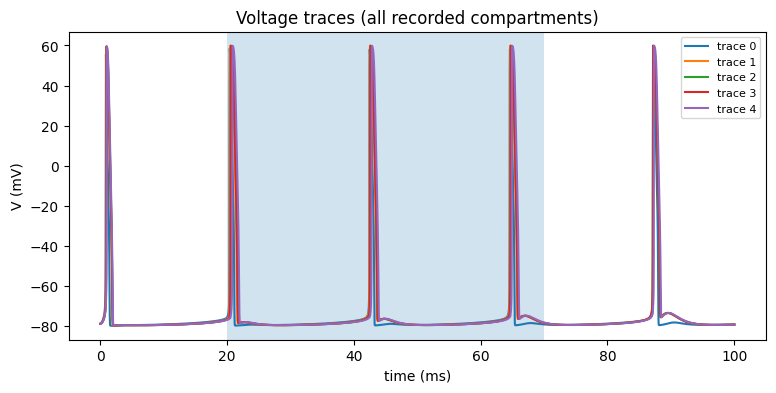

In [43]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

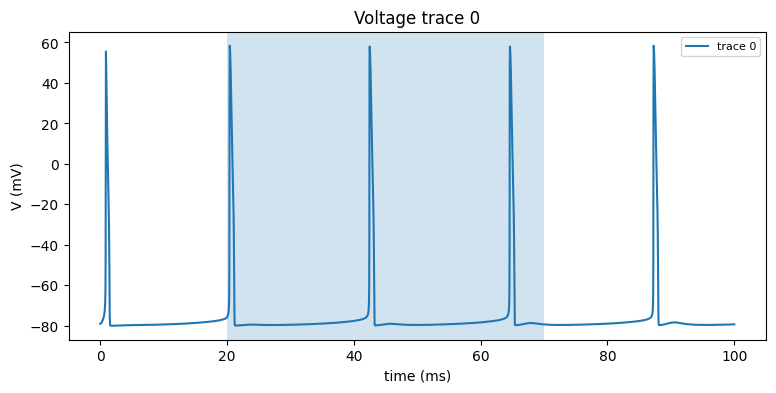

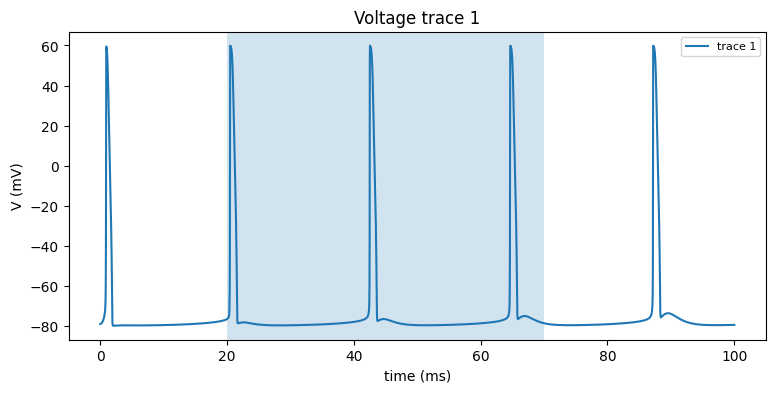

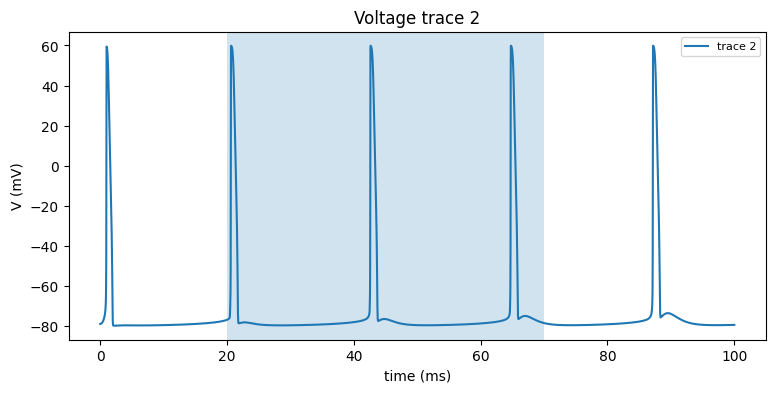

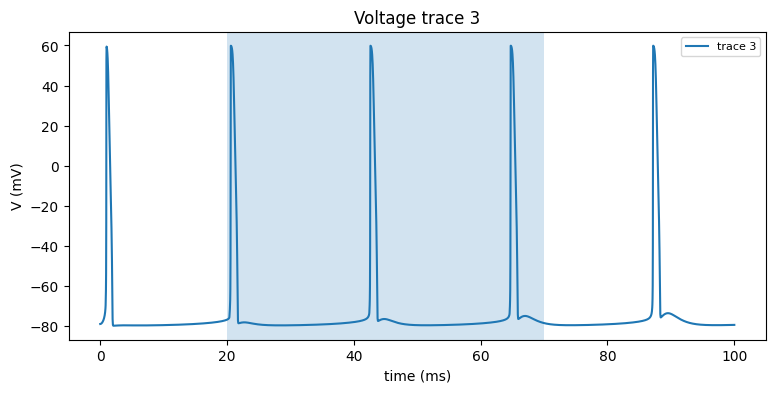

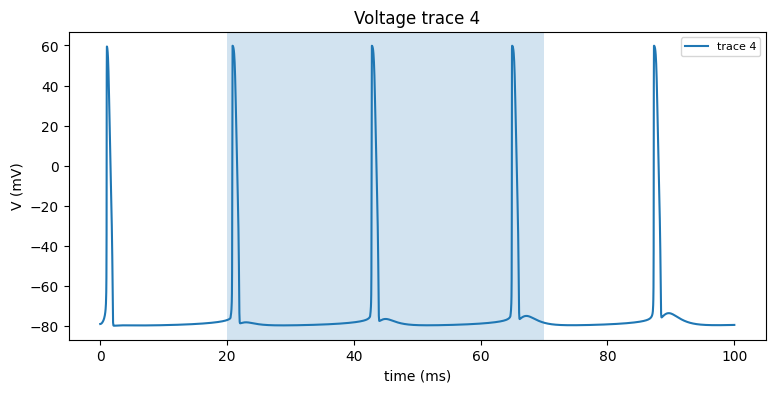

In [44]:

v_arr = np.array(v)      # (5, T) in your case
T = v_arr.shape[1]
t = np.arange(T) * dt

for i in range(v_arr.shape[0]):
    plt.figure(figsize=(9, 4))
    plt.plot(t, v_arr[i], label=f"trace {i}")
    plt.axvspan(20.0, 70.0, alpha=0.2)
    plt.xlabel("time (ms)")
    plt.ylabel("V (mV)")
    plt.title(f"Voltage trace {i}")
    plt.legend(fontsize=8)
    plt.show()

In [153]:
cell.delete_stimuli()
cell.delete_recordings()

cell.branch(0).comp(0).stimulate(I)   # soma only
cell.record("v")                      # record all 5 nodes

v = jx.integrate(cell, delta_t=dt)

Iext = np.array(cell.externals["i"])
print("max per node:", Iext.max(axis=1))  # should be [0.2, 0, 0, 0, 0] (or similar)

Added 1 external_states. See `.externals` for details.
Added 5 recordings. See `.recordings` for details.
max per node: [0.]


In [128]:
print("externals['i'] shape:", np.array(cell.externals["i"]).shape)

externals['i'] shape: (1, 4001)


In [154]:
v_arr = np.array(v)  # expect (5, T)
print("v shape:", v_arr.shape)
for i in range(1, v_arr.shape[0]):
    print(i, "max|diff from trace0| =", float(np.max(np.abs(v_arr[i] - v_arr[0]))))

v shape: (5, 4002)
1 max|diff from trace0| = 131.20809123267807
2 max|diff from trace0| = 135.62743169104374
3 max|diff from trace0| = 131.20809123267807
4 max|diff from trace0| = 135.62743169104374


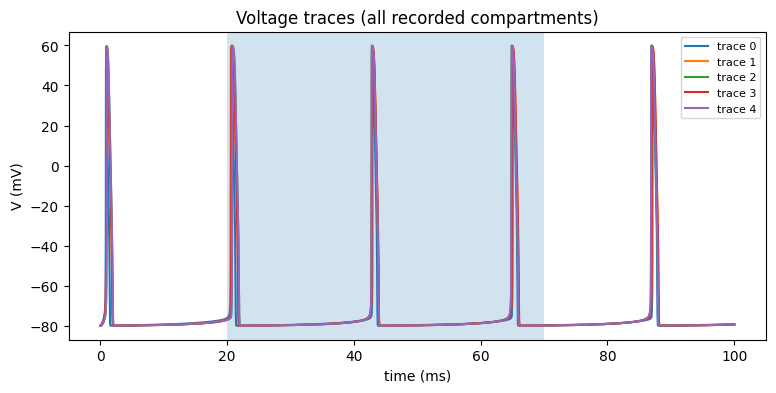

In [155]:
v_arr = np.array(v)      
T = v_arr.shape[1]
t = np.arange(T) * dt

plt.figure(figsize=(9,4))
for i in range(v_arr.shape[0]):
    plt.plot(t, v_arr[i], label=f"trace {i}")

plt.axvspan(20.0, 70.0, alpha=0.2)
plt.xlabel("time (ms)")
plt.ylabel("V (mV)")
plt.legend(fontsize=8)
plt.title("Voltage traces (all recorded compartments)")
plt.show()

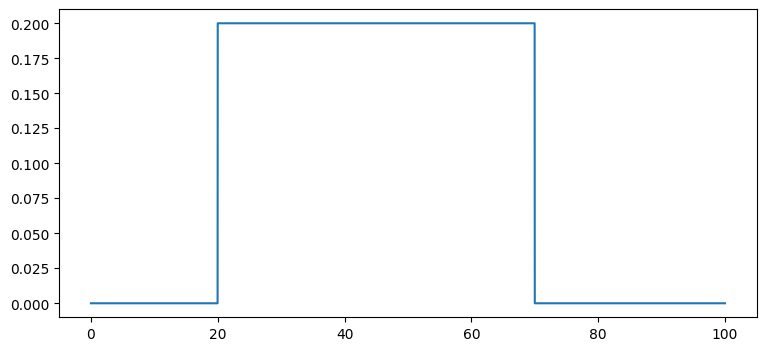

In [117]:
# print step current 

I_arr = np.array(I)
t = np.arange(I_arr.shape[0]) * dt

plt.figure(figsize=(9,4))
plt.plot(t, I_arr)

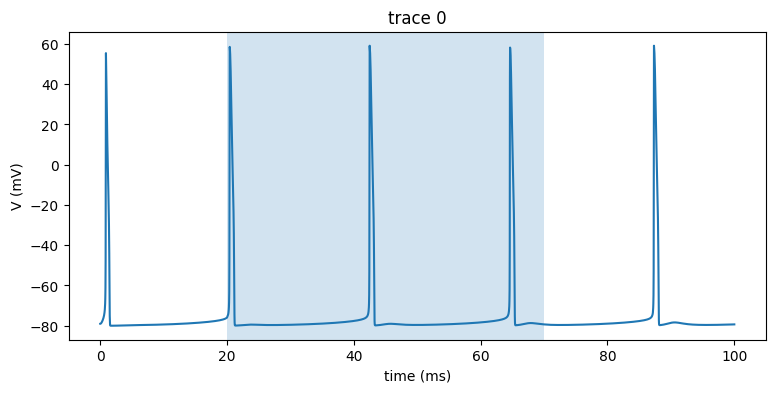

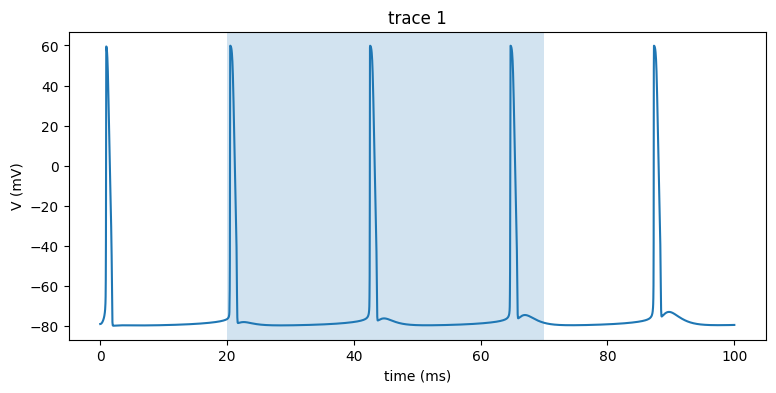

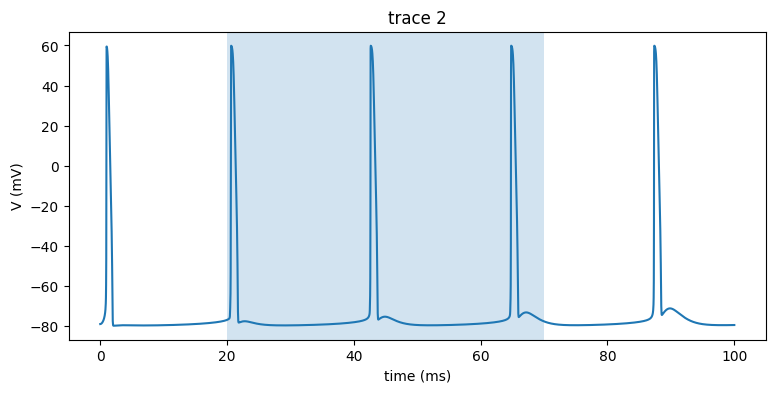

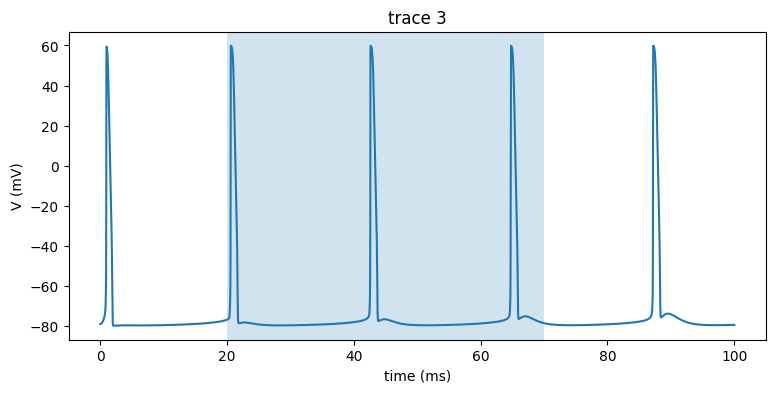

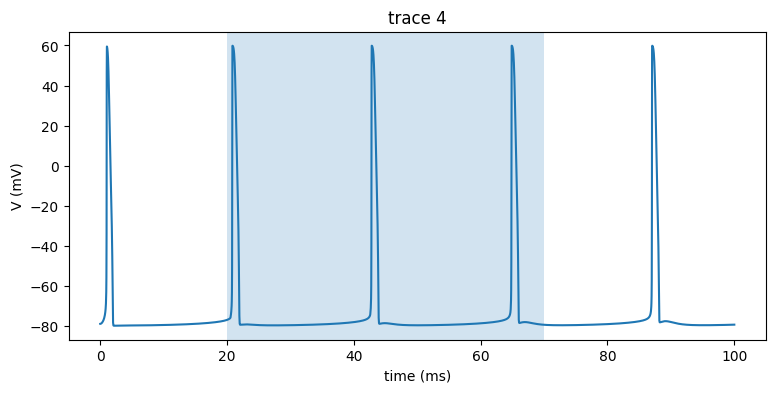

In [99]:
v_arr = np.array(v)
t = np.arange(v_arr.shape[1]) * dt

for i in range(v_arr.shape[0]):
    plt.figure(figsize=(9,4))
    plt.plot(t, v_arr[i])
    plt.axvspan(20.0, 70.0, alpha=0.2)
    plt.xlabel("time (ms)")
    plt.ylabel("V (mV)")
    plt.title(f"trace {i}")
    plt.show()

In [34]:
print(cell.nodes.columns)

Index(['local_cell_index', 'local_branch_index', 'local_comp_index', 'length',
       'radius', 'axial_resistivity', 'capacitance', 'v', 'area', 'volume',
       ...
       'vm1_CaLVA', 'vm2_CaLVA', 'vh1_CaLVA', 'vh2_CaLVA', 'wm1_CaLVA',
       'wm2_CaLVA', 'wh1_CaLVA', 'wh2_CaLVA', 'm_CaLVA', 'h_CaLVA'],
      dtype='object', length=113)


In [ ]:
# from jaxley.pumps import CaPump
# cell.insert(CaPump())

In [79]:
post_cell = cell 